In [1]:
import os
import tensorflow as tf
import numpy as np
from itertools import cycle
from PIL import Image

import time

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

from numpy import argmax, array
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.metrics import top_k_categorical_accuracy
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.utils import plot_model
from keras.metrics import top_k_categorical_accuracy

from keras.layers.convolutional import Conv2DTranspose , Conv2D

2023-06-12 16:39:53.651753: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 16:39:53.777971: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-12 16:39:54.307442: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vlad/root/lib:/home/vlad/anaconda3/lib/:/home/vlad/anaconda3/lib/python3.9/site-packages/nvidia/cudnn/lib
2023-06-12 16:39:54.307529: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could no

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2023-06-12 16:39:55.682406: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-12 16:39:55.746987: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-12 16:39:55.765606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-12 16:39:55.778266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
train_data_dir='/home/vlad/Desktop/train_1/'
validate_data_dir='/home/vlad/Desktop/allimages/'
test_data_dir='/home/vlad/Desktop/test_1/'

In [4]:
# Define Constants
img_height = 100
img_width = 100

batch_size_train=350
batch_size_test=175
epochs=100

In [5]:
input_shape = (img_width, img_height, 1)

In [6]:
# Train Datagen
print("\nInitializing Training Data Generator:")
train_datagen = ImageDataGenerator(
                                rescale=1. / 255,
                                #width_shift_range=2,
                                #height_shift_range=2,
                                #rotation_range=45,
                                #shear_range=1,
                                zoom_range=1,
                                featurewise_center=False,
                                featurewise_std_normalization=True)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size_train,
    color_mode="grayscale",
    class_mode='categorical')
print("")

# Validation Datagen
print("Initializing Validation Data Generator:")
validation_datagen = ImageDataGenerator(
                                rescale=1. / 255,
                                #width_shift_range=2,
                                #height_shift_range=2,
                                #rotation_range=45,
                                #shear_range=1,
                                zoom_range=1,
                                featurewise_center=False,
                                featurewise_std_normalization=True)
valid_generator = validation_datagen.flow_from_directory(
    validate_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size_test,
    color_mode="grayscale",
    class_mode='categorical')
print("")

# Test Datagen
print("Initializing Test Data Generator:")
test_datagen = ImageDataGenerator(
                                rescale=1. / 255,
                                #width_shift_range=2,
                                #height_shift_range=2, 
                                #rotation_range=45,
                                #shear_range=1,
                                zoom_range=1,
                                featurewise_center=False,
                                featurewise_std_normalization=True)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size_test,
    color_mode="grayscale",
    class_mode='categorical')
print("")


Initializing Training Data Generator:
Found 7300 images belonging to 1 classes.

Initializing Validation Data Generator:
Found 0 images belonging to 0 classes.

Initializing Test Data Generator:
Found 5840 images belonging to 1 classes.



/home/vlad/anaconda3/lib/python3.9/site-packages/keras/preprocessing/image.py:1462: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(


In [7]:
#create model
model = Sequential()

#Encoder

model.add(Conv2D(16, (3, 3), input_shape=input_shape))
model.add(Activation('linear'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(8, (3, 3)))
model.add(Activation('linear'))
model.add(MaxPooling2D(pool_size=(2, 2)))


#Decoder

model.add(Conv2DTranspose(8, (3, 3)))
model.add(Activation('linear'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2DTranspose(16, (3, 3)))
model.add(Activation('linear'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(1, (3, 3)))
model.add(Activation('linear'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(16))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [8]:
#compile model
#num_classes = 3

#def top_3_categorical_accuracy(y_true, y_pred):
#    return top_k_categorical_accuracy(y_true, y_pred, k=10)

model.compile(optimizer = tf.optimizers.SGD(learning_rate=0.00008),
              loss = 'SparseCategoricalCrossentropy',
              metrics = ['SparseCategoricalAccuracy'])

In [9]:
earlystopping = callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                        mode='max', 
                                        patience=5, 
                                        restore_best_weights=True)

In [10]:
#fit model
print("Starting Training...")
history = model.fit(
        train_generator,
        steps_per_epoch=20,
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=20,
        callbacks =[earlystopping],
        shuffle=True)
print("Done!\n\n")

Starting Training...


/home/vlad/anaconda3/lib/python3.9/site-packages/keras/preprocessing/image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/home/vlad/anaconda3/lib/python3.9/site-packages/keras/preprocessing/image.py:1873: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/100


2023-06-12 16:39:59.043980: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


 1/20 [>.............................] - ETA: 56s - loss: 1.1159 - sparse_categorical_accuracy: 0.0914

2023-06-12 16:40:00.070123: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


20/20 [==============================] - 11s 432ms/step - loss: 1.1155 - sparse_categorical_accuracy: 0.0773 - val_loss: 1.1145 - val_sparse_categorical_accuracy: 0.0951
Epoch 2/100
20/20 [==============================] - 8s 425ms/step - loss: 1.1135 - sparse_categorical_accuracy: 0.0814 - val_loss: 1.1122 - val_sparse_categorical_accuracy: 0.0957
Epoch 3/100
20/20 [==============================] - 8s 427ms/step - loss: 1.1117 - sparse_categorical_accuracy: 0.0879 - val_loss: 1.1101 - val_sparse_categorical_accuracy: 0.1034
Epoch 4/100
20/20 [==============================] - 9s 433ms/step - loss: 1.1091 - sparse_categorical_accuracy: 0.1095 - val_loss: 1.1081 - val_sparse_categorical_accuracy: 0.1166
Epoch 5/100
20/20 [==============================] - 9s 435ms/step - loss: 1.1074 - sparse_categorical_accuracy: 0.1239 - val_loss: 1.1057 - val_sparse_categorical_accuracy: 0.1491
Epoch 6/100
20/20 [==============================] - 8s 431ms/step - loss: 1.1055 - sparse_categorical_acc

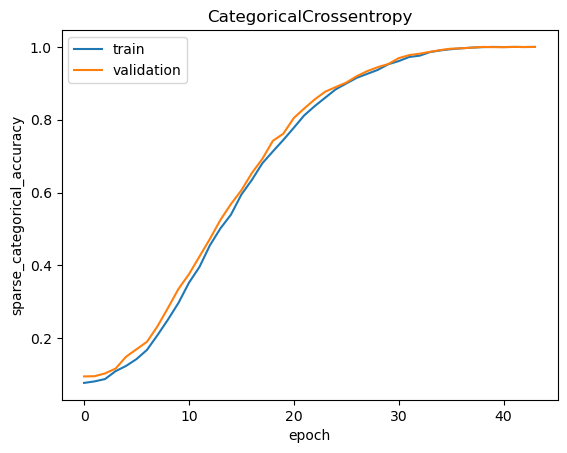

In [11]:
def plot_hist(hist):
    plt.plot(hist.history['sparse_categorical_accuracy'])
    plt.plot(hist.history['val_sparse_categorical_accuracy'])
    plt.title('CategoricalCrossentropy')
    plt.ylabel('sparse_categorical_accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

In [12]:
model.evaluate(test_generator)

34/34 [==============================] - 5s 141ms/step - loss: 1.0301 - sparse_categorical_accuracy: 0.9991


[1.030081033706665, 0.9991438388824463]

Example Predicted Set:




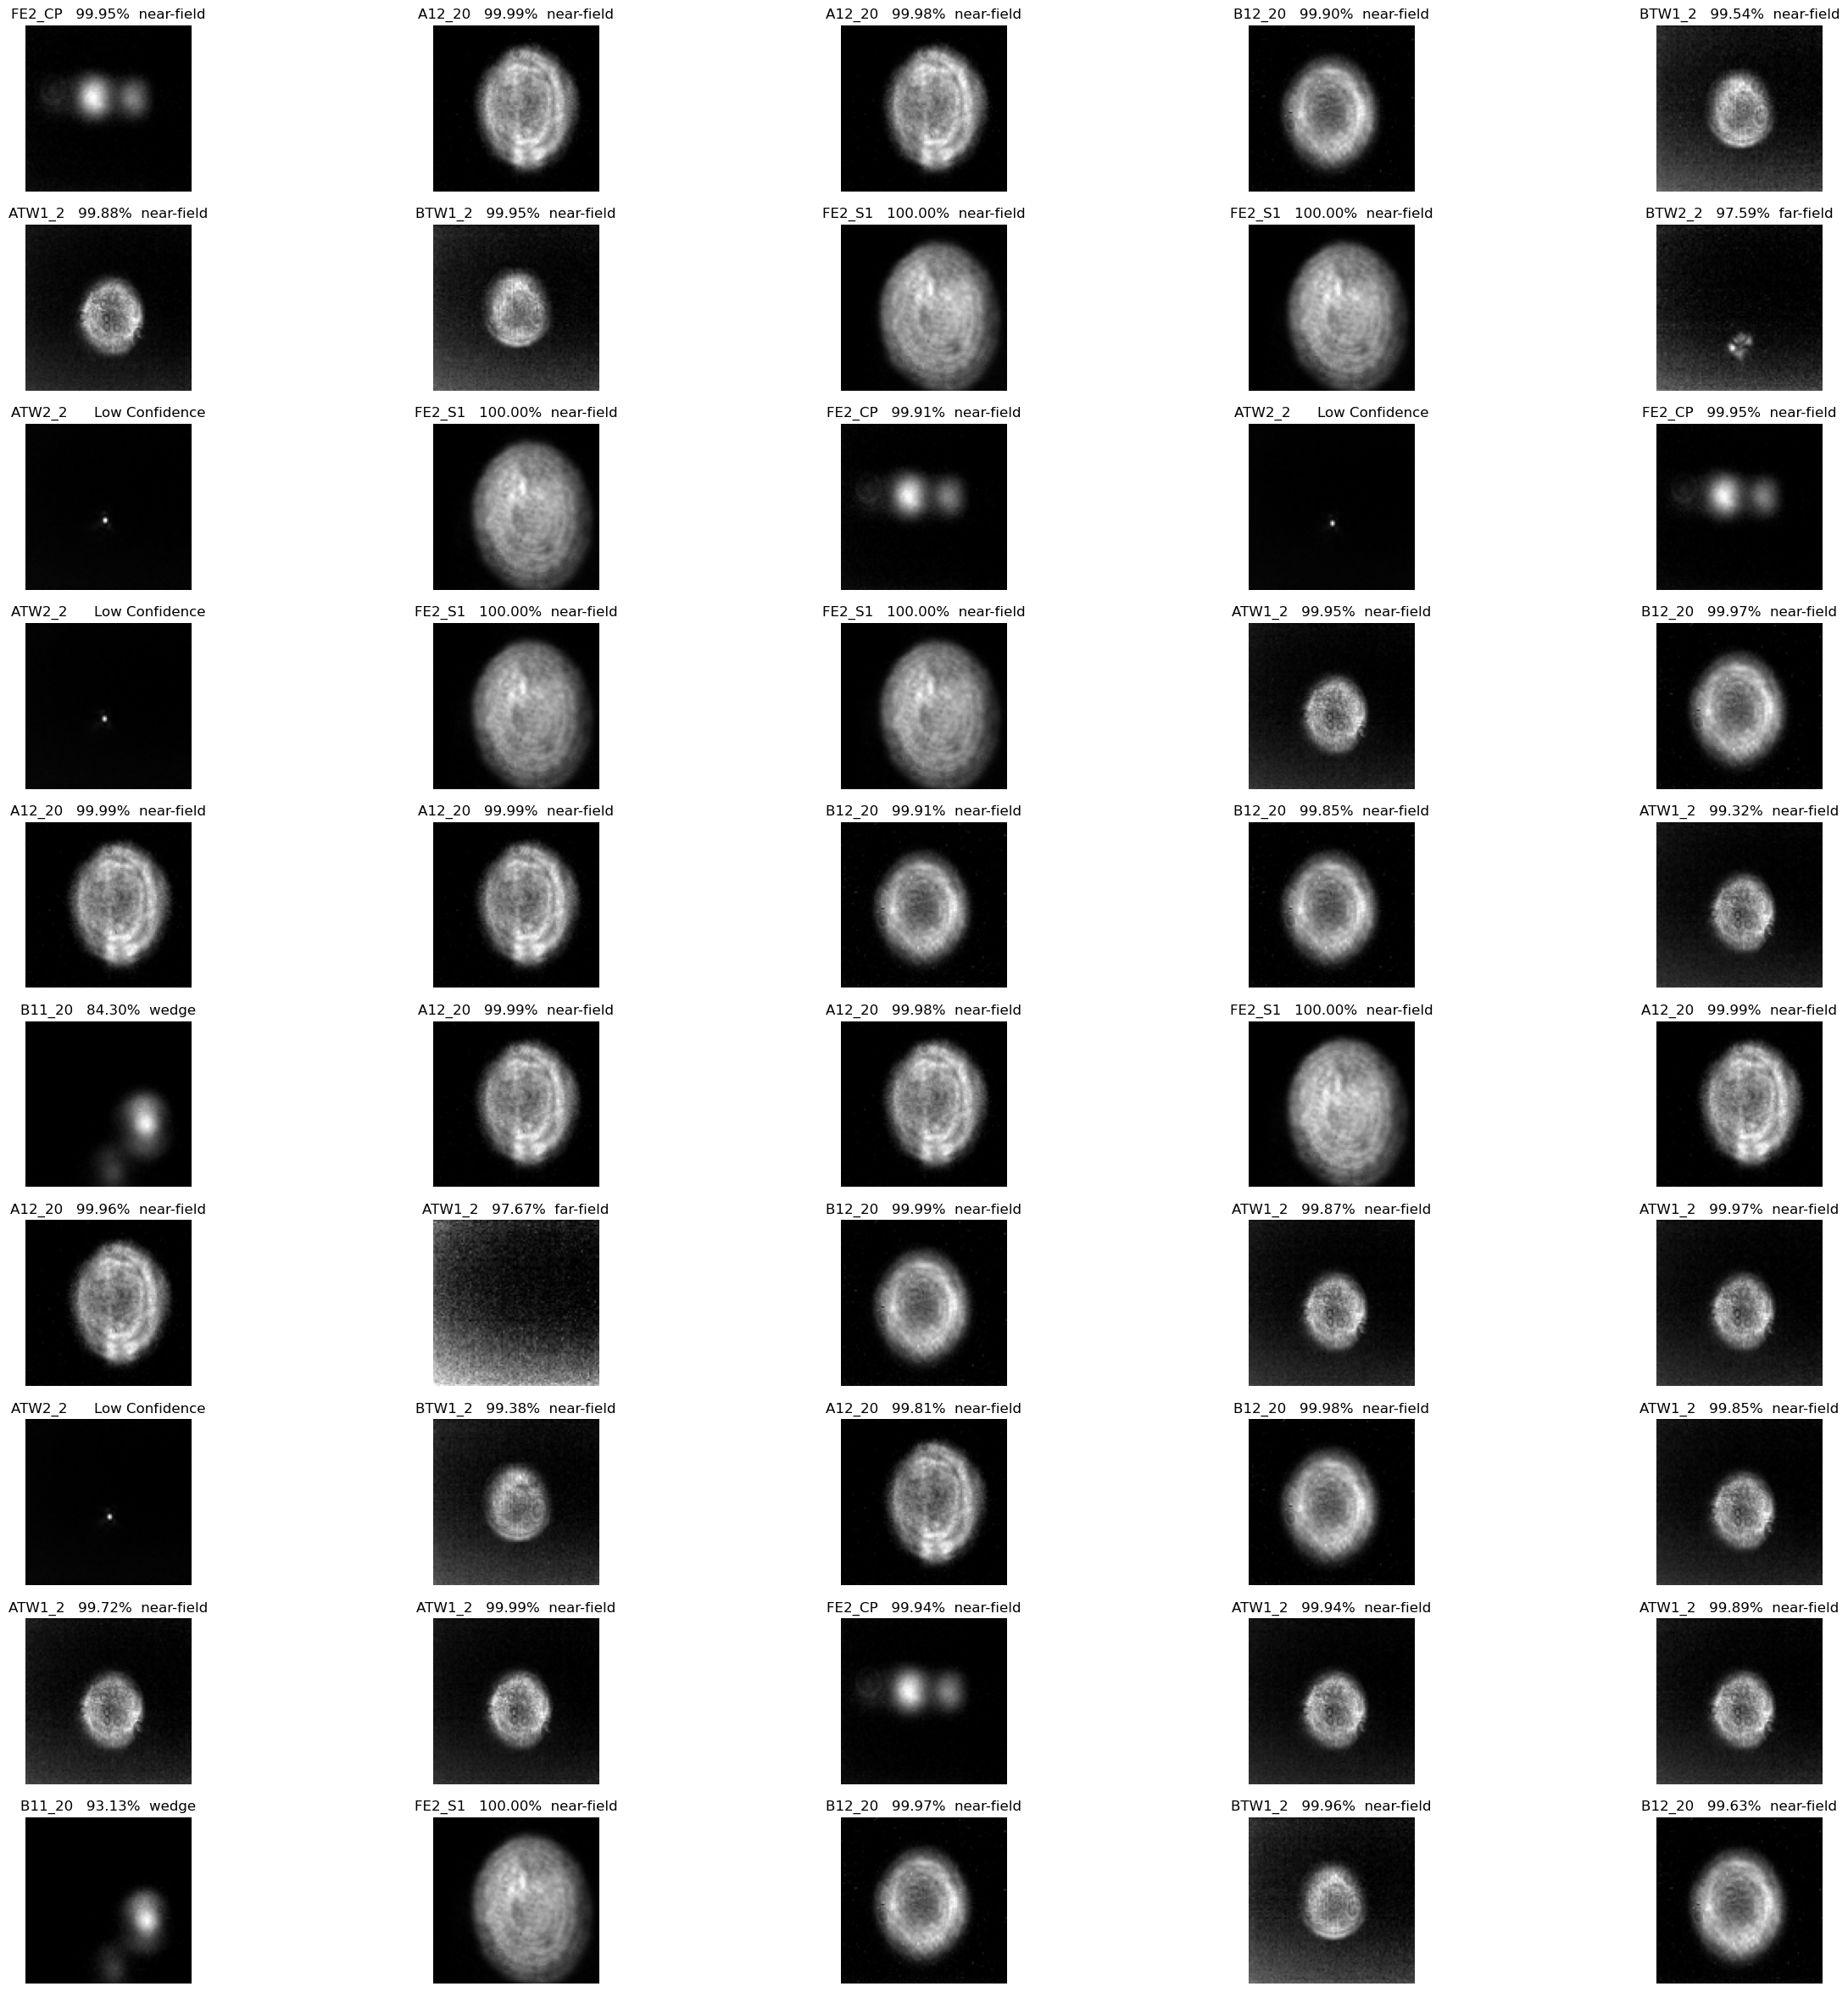

In [17]:
path = '/home/vlad/Desktop/allimages/'
dirList = os.listdir(path)
plt.figure(figsize=(30,30))
count = 0
imageList = []
label = 'Low Confidence'

one = 0
two = 0
three = 0

for i in dirList[:200]:
    #print(i)
    image = Image.open(path + str(i))
    #plt.figure()
    #plt.imshow(image)
    #print(f"Original size : {image.size}")
        
    image = image.resize((100, 100))
    #print(f"New size : {image.size}")

    x = np.asarray(image)   
    x = np.expand_dims(x, axis=0)
    #print(x/255.0)
    images = np.vstack([x])
    #print(images[0][50])
    classes = model.predict(
    images,
    batch_size=1,
    verbose='off',
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=True)

    classifier = "   Low Confidence"
    
    score = float(classes[0][0])
    #print(f"   This image is {100 * (score):.2f}% far-field.")
    if score > 0.66:
        classifier = f"{100 * (score):.2f}%  far-field"
        label = ['far-field']
        one += 1
    score = float(classes[0][1])
    #print(f"   This image is {100 * (score):.2f}% wedge.")
    if score > 0.66:
        classifier = f"{100 * (score):.2f}%  wedge"
        label = ['wedge']
        two += 1
    score = float(classes[0][2])
    #print(f"   This image is {100 * (score):.2f}% near-field.")
    if score > 0.66:
        classifier= f"{100 * (score):.2f}%  near-field"
        label = ['near-field']
        three += 1
    
    imageList += label
    
    if count < 50:
        ax=plt.subplot(10,5,count+1)
        plt.imshow(image, cmap='gray')
        plt.title(str(i[0:6] + "   " + classifier))
        count += 1
        plt.axis('off')
print("Example Predicted Set:\n\n")

In [18]:
nameList = []
index = 0
while index < len(dirList[:200]):
    if dirList[index][0:3] == 'B12':
        nameList += ['near-field']
    elif dirList[index][0:3] == 'B11':
        nameList += ['wedge']
    elif dirList[index][0:4] == 'ATW1':
        nameList += ['near-field']
    elif dirList[index][0:5] == 'FE2_C':
        nameList += ['wedge']
    elif dirList[index][0:5] == 'FE2_S':
        nameList += ['near-field']
    elif dirList[index][0:4] == 'BTW1':
        nameList += ['near-field']
    elif dirList[index][0:3] == 'A12':
        nameList += ['near-field']
    elif dirList[index][0:4] == 'ATW2':
        nameList += ['far-field']
    else:
        nameList += ['far-field']
    index += 1    

In [19]:
from sklearn.metrics import confusion_matrix

y_true = nameList
y_pred = imageList
confusion_matrix(y_true, y_pred)

array([[ 23,  10,   5],
       [  1, 125,   0],
       [  0,  19,  17]])

High Confidence Images: 92.50 % of total (greater than 66% confidence value).


21/24 far-field predictions: 1-
21/22 wedge predictions: 2-
143/154 near-field predictions: 0-


165 values correct out of 200: 82.50% model accuracy


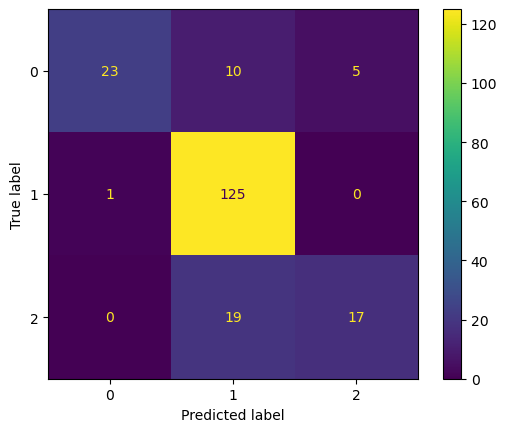

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)

farTrue=cm[0][0]+cm[1][0]+cm[2][0]
nearTrue=cm[0][1]+cm[1][1]+cm[2][1]
wedgeTrue=cm[0][2]++cm[1][2]+cm[2][2]

correctValue = cm[0][0]+cm[1][1]+cm[2][2]

print(f"High Confidence Images: {100*(one+two+three)/(index):.2f} % of total (greater than 66% confidence value).")
print("\n")

print(f"{(one)}/{(farTrue)} far-field predictions: 1-")
print(f"{(two)}/{(wedgeTrue)} wedge predictions: 2-")
print(f"{(three)}/{(nearTrue)} near-field predictions: 0-")


print("\n")
print(f"{correctValue} values correct out of {index}: {100 * (correctValue/index):.2f}% model accuracy")
cm_display = ConfusionMatrixDisplay(cm).plot()